<a href="https://colab.research.google.com/github/Gail529/AES/blob/main/automated_essay_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing  Necessary Modules

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
 
import re
import string
import warnings
warnings.filterwarnings("ignore")  
from gensim.models import Word2Vec
 
 
#essay preprocessing 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
import re
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#training the neural network 
from tensorflow.keras.layers import Embedding
from keras.models import Sequential, load_model, model_from_config
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Flatten

from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score
import keras.backend as K

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Preprocessing

In [3]:
#reading data set
essay_data= pd.read_excel('/content/training_set_rel3.xlsx',usecols=['essay_id','essay','domain1_score'])
essay_data.head(2)

,essay_id,essay,domain1_score
0,1,"Dear local newspaper, I think effects computer...",8.0
1,2,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0


In [4]:
x=essay_data['essay']
y=essay_data['domain1_score']
len(x) 

12978

In [5]:
#missing values
essay_data['domain1_score'] = essay_data['domain1_score'].fillna(essay_data['domain1_score'].mean())
print(essay_data.isnull().sum().sum())
print(np.any(np.isnan(y).sum()))

0
False


In [6]:
#preprocessing the essays
def sent_tokenize(text):
    stripped_essay = text.strip()
    #tokenization 
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay)
    
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        #removing punctuations and non alphanumeric characters
        clean_sentence = re.sub("[^a-zA-Z0-9]"," ", raw_sentence)
        #lowercasing
        words = clean_sentence.lower().split()
        #removing stopwords
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        tokenized_sentences.append(words)

    return tokenized_sentences


In [7]:
#sentences for the word2Vec model
sentences=[]
for essay in x:
    sentences += sent_tokenize(essay)

In [8]:
sentences[100]

['result', 'computers', 'would', 'improve', 'way', 'learn']

# Word Embedding

In [9]:
text_dim = 300
print("Training Word2Vec model...")
wordvec_model = Word2Vec(sentences, size=text_dim, window=5, min_count=3, workers=4, sg=1)
print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))
wordvec_model.save('wordvec_model')
print("Word2Vec model saved.")

Training Word2Vec model...
Word2Vec model created.
13134 unique words represented by 300 dimensional vectors
Word2Vec model saved.


In [10]:
#essays
cleaned_essays=[]
for i in range(0,len(x)):
    essay=x[i]
    cleaned_essays.append(sent_tokenize(essay))
    

In [11]:
def clean_essays(essay):
    clean_essay= re.sub("[^a-zA-Z]", " ",essay)
    words = essay.lower().split()
    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops]
    return (words)

cleaned_essays = []
for essay in x:
        cleaned_essays.append(clean_essays(essay))

In [12]:
#creating the embedding matrix
def create_average_vec(essay):
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    for word in essay:
        if word in wordvec_model.wv.vocab:
            average = np.add(average, wordvec_model.wv[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

cleaned_vec = np.zeros((len(x),text_dim), dtype="float32")  
for i in range(len(cleaned_essays)):
    cleaned_vec[i] = create_average_vec(cleaned_essays[i])

print("Word vectors for all essays in the training data set are of shape:", cleaned_vec.shape)


Word vectors for all essays in the training data set are of shape: (12978, 300)


In [28]:
#splitting the training and validation set
data_split=0.8
train_samples=int(len(cleaned_vec)*data_split)

x_train = np.array(cleaned_vec[:train_samples])
x_test = np.array(cleaned_vec[train_samples:])
y_train = np.array(y[:train_samples])
y_test = np.array(y[train_samples:])

print("x_train" ,len(x_train))
print("x_test" ,len(x_test))
print("y_train" ,len(y_train))
print("y_test" ,len(y_test))

x_train 10382
x_test 2596
y_train 10382
y_test 2596


In [14]:
#playing around with the hyperparameters
def get_model():
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

def get_model2():
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()
    return model

def get_model3():
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    model.summary()
    return model

def get_model4():
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()
    return model



In [29]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    

lstm_model = get_model3()
history=lstm_model.fit(x_train, y_train, batch_size=100, epochs=20,validation_data=(x_test, y_test))

y_pred = lstm_model.predict(x_test)
lstm_model.save('final_lstm.h5')

# Round y_pred to the nearest integer.
y_pred = np.around(y_pred)

# Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
result = cohen_kappa_score(y_test,y_pred,weights='quadratic')
print("Kappa Score: {}".format(result))



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
104/104 [==============================] - 9s 38ms/step - loss: 14.3417 - mae: 2.7420 - val_loss: 519.4193 - val_mae: 19.3189
Epoch 2/20
104/104 [==============================] - 3s 33ms/step - loss: 12.2895 - mae: 2.4458 - val_loss: 

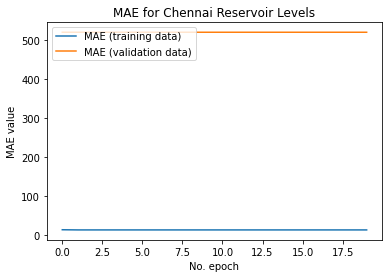

In [30]:
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

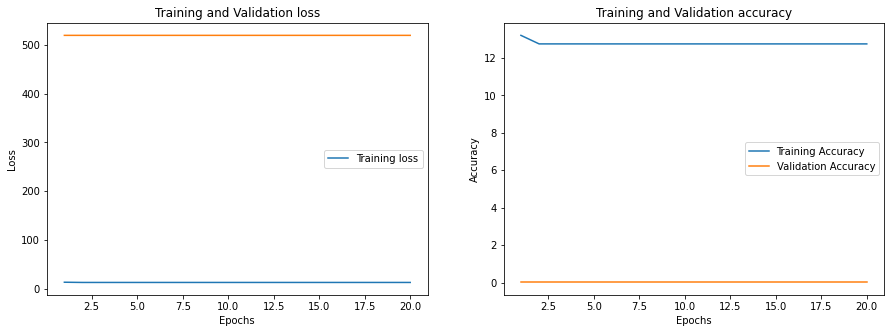

In [27]:
import matplotlib.pyplot as plt


loss= history.history['loss']
val_loss=history.history['val_loss']

acc=history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1,len(loss)+1)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(epochs,loss,label='Training loss')
ax1.plot(epochs,val_loss)
ax1.set_title('Training and Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()


ax2.plot(epochs,loss,label='Training Accuracy')
ax2.plot(epochs,val_acc,label='Validation Accuracy')
ax2.set_title('Training and Validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()


plt.show()


In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    

lstm_model = get_model2()
lstm_model.fit(x_train, y_train, batch_size=100, epochs=20)
y_pred = lstm_model.predict(x_test)
lstm_model.save('final_lstm2.h5')

# Round y_pred to the nearest integer.
y_pred = np.around(y_pred)

# Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
result = cohen_kappa_score(y_test,y_pred,weights='quadratic')
print("Kappa Score: {}".format(result))



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
104/104 [==============================] - 8s 31ms/step - loss: 6.9695 - mae: 1.8185
Epoch 2/20
104/104 [==============================] - 3s 30ms/step - loss: 2.2457 - mae: 1.1317
Epoch 3/20
104/104 [==============================] - 

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    

lstm_model = get_model4()
lstm_model.fit(x_train, y_train, batch_size=100, epochs=20)
y_pred = lstm_model.predict(x_test)
lstm_model.save('final_lstm4.h5')

# Round y_pred to the nearest integer.
y_pred = np.around(y_pred)

# Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
result = cohen_kappa_score(y_test,y_pred,weights='quadratic')
print("Kappa Score: {}".format(result))



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
104/104 [==============================] - 7s 29ms/step - loss: 14.0811 - mae: 2.6886
Epoch 2/20
104/104 [==============================] - 3s 29ms/step - loss: 12.9203 - mae: 2.5200
Epoch 3/20
104/104 [==============================] 